## Input paths

In [1]:
image_path="data/"
input_data_file="coordinates.csv"

# Person Re-Id
1. Extract Features using Resnet CNN from images.
2. Extract attribute vector from images.
3. Evaluation
4. Display output 

###  Extract Features using Resnet CNN from images.

This part loads the model trained for feature Map extraction
- A resnet50 model is trained on openly available Market 1501 dataset
    - Trained on **12186** images
    - Validated on **751** images
    - Trained for **15** epochs
    - **Pytorch** framework used at the backend
- We use the model to generate the feature map of each individual present on the image and store the feature map in the database

In [2]:
# Import necessary libraries
import torch
from PIL import Image
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import time
import os
import scipy.io
import math
from model import ft_net
from sklearn import preprocessing
from scipy import spatial
import pandas as pd
from tqdm import tqdm
ms = [1]

#### Function for extracting feature vector from an image

In [3]:
# Function to load model network
def load_network(network):
    save_path = os.path.join('./model','features_model','net_last.pth')
    network.load_state_dict(torch.load(save_path))
    return network

In [4]:
# Function to flip image
def fliplr(img):
    '''flip horizontal'''
    inv_idx = torch.arange(img.size(3)-1,-1,-1).long()  # N x C x H x W
    img_flip = img.index_select(3,inv_idx)
    return img_flip

In [5]:
# Loading model trained for Feature vector extraction
model_structure = ft_net(751)    
model = load_network(model_structure)
model.classifier.classifier = nn.Sequential()
model = model.eval()
model_structure

ft_net(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(6

In [6]:
# Setting parameter for Transformation and Normalization of dataset
scaler = transforms.Resize((256,128), interpolation=3)
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

In [7]:
# Function to extract feature vector of an Image
def get_feature_vector(img):
    # Load the image with Pillow library
    features = torch.FloatTensor()  
    # Create a PyTorch Variable with the transformed image
    t_img = normalize(to_tensor(scaler(img))).unsqueeze(0)
    ff = torch.FloatTensor(1,512).zero_()
    for i in range(2):
        if(i==1):
            t_img = fliplr(t_img)
        input_img = Variable(t_img)
        for scale in ms:
            if scale != 1:
                input_img = nn.functional.interpolate(input_img, scale_factor=scale, mode='bicubic', align_corners=False)
            outputs = model(input_img)
            ff += outputs
    fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
    ff = ff.div(fnorm.expand_as(ff))
    features = torch.cat((features,ff.data.cpu()), 0)
    return features

## Extract attribute vector from image
### Attribute examples are hat, gender, hair (long/short), upper color, lower color

This part loads another model trained for Person Attribute recognition. 

- We trained the model on RAP v2.0 (Richly Annotated Dataset for Pedestrian Attribute Recognition) having **84929** well annotated images
- Rap v2.0 is not freely available and we had to sign an agreement to use this dataset
- The author of the paper https://www.researchgate.net/publication/301817457_A_Richly_Annotated_Dataset_for_Pedestrian_Attribute_Recognition, Dangwei Li helped us with the dataset
- We trained our model to identify 82 attributes as follows
    -  [Female, AgeLess16, Age17-30, Age31-45, Age46-60, BodyFat, BodyNormal, BodyThin, Customer, Employee, hs-BaldHead, hs-LongHair, hs-BlackHair, hs-Hat, hs-Glasses, ub-Shirt, ub-Sweater, ub-Vest, ub-TShirt, ub-Cotton, ub-Jacket, ub-SuitUp, ub-Tight, ub-ShortSleeve, ub-Others, ub-ColorBlack, ub-ColorWhite, ub-ColorGray, up-ColorRed, ub-ColorGreen, ub-ColorBlue, ub-ColorSilver, ub-ColorYellow, ub-ColorBrown, ub-ColorPurple, ub-ColorPink, ub-ColorOrange, ub-ColorMixture, ub-ColorOther, lb-LongTrousers, lb-Skirt, lb-ShortSkirt, lb-Dress, lb-Jeans, lb-TightTrousers, lb-ColorBlack, lb-ColorWhite, lb-ColorGray, lb-ColorRed, lb-ColorGreen, lb-ColorBlue, lb-ColorSilver, lb-ColorYellow, lb-ColorBrown, lb-ColorPurple, lb-ColorPink, lb-ColorOrange, lb-ColorMixture, lb-ColorOther, shoes-Leather, shoes-Sports, shoes-Boots, shoes-Cloth, shoes-Casual, shoes-Other, attachment-Backpack, attachment-ShoulderBag, attachment-HandBag, attachment-Box, attachment-PlasticBag, attachment-PaperBag, attachment-HandTrunk, attachment-Other, action-Calling, action-Talking, action-Gathering, action-Holding, action-Pushing, action-Pulling, action-CarryingByArm, action-CarryingByHand, action-Other]
- We then trained a resnet50 model and got an MAP (Mean Average Precision of 71%)
    - Trained on **67,433** images
    - Validated on **16,589** images
    - Trained for **150** epochs
    - **Pytorch** framework used at the backend
- For Person Re-identification we are using score of each 82 attribute as predicted by our model


In [8]:
# Import necessary libraries
import sys
import os
import numpy as np
import random
import math
import torch
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch.nn.parallel import DataParallel
import pickle
import time
from PIL import Image, ImageFont, ImageDraw
import cv2
from baseline.model.DeepMAR import DeepMAR_ResNet50
from baseline.utils.utils import str2bool
from baseline.utils.utils import save_ckpt, load_ckpt
from baseline.utils.utils import load_state_dict 
from baseline.utils.utils import set_devices
from baseline.utils.utils import set_seed

In [9]:
# Class for attribute recognition
class Config(object):
    def __init__(self):
        self.sys_device_ids = (0,)
        # random
        self.set_seed = False
        if self.set_seed:
            self.rand_seed = 0
        else: 
            self.rand_seed = None
        self.resize = (224,224)
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        # utils
        self.load_model_weight = True
        self.model_weight_file = 'model/attributes_model/ckpt_epoch100.pth'
        dataset= pickle.load(open('model/attributes_model/rap2_dataset.pkl', 'rb'))
        self.att_list = [dataset['att_name'][i] for i in dataset['selected_attribute']]
        # model
        model_kwargs = dict()
        model_kwargs['num_att'] = len(self.att_list)
        model_kwargs['last_conv_stride'] = 2
        self.model_kwargs = model_kwargs

In [10]:
# Creating object for Attribute Recognition
cfg = Config()
if cfg.set_seed:
    set_seed( cfg.rand_seed )
# init the gpu ids
set_devices(cfg.sys_device_ids)
# dataset 
normalize = transforms.Normalize(mean=cfg.mean, std=cfg.std)
test_transform = transforms.Compose([
        transforms.Resize(cfg.resize),
        transforms.ToTensor(),
        normalize,])

In [11]:
# Loading model trained for Attribute Recognition
modelAtt = DeepMAR_ResNet50(**cfg.model_kwargs)
if cfg.load_model_weight:
    map_location = (lambda storage, loc:storage)
    ckpt = torch.load(cfg.model_weight_file, map_location=map_location)
    modelAtt.load_state_dict(ckpt['state_dicts'][0])
modelAtt.eval()

/home/jaditya/notebooks/evaluation/person_reid/baseline/model/DeepMAR.py:41: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  init.normal(self.classifier.weight, std=0.001)
/home/jaditya/notebooks/evaluation/person_reid/baseline/model/DeepMAR.py:42: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.classifier.bias, 0)


DeepMAR_ResNet50(
  (base): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0):

#### Funtion for extracting attribute vector

In [12]:
def get_att_vector(img):
    img_trans = test_transform(img) 
    img_trans = torch.unsqueeze(img_trans, dim=0)
    img_var = Variable(img_trans)
    score = modelAtt(img_var).data.cpu().numpy()
    return score

## Evaluation

### Load input data file that contains image bounding box co-ordinates

In [3]:
# Loading Coordinates csv gives the coordinate for each Person Present in the Image 
# Coordinates are extracted using Tensorflow Object detection Api
input_df = pd.read_csv(input_data_file)
input_df = input_df.drop(['Unnamed: 0'], axis = 1)
input_df.columns

Index(['filename', 'x1', 'y1', 'x2', 'y2'], dtype='object')

In [4]:
# For example Frame0.jpg image has 8 Persons and .CSV file contains coordinates for each person
# Likewise for other images
input_df.head(10)

filename    x1   y1    x2   y2
0  frame0.jpg  1009  138  1259  703
1  frame0.jpg   115  113   423  713
2  frame0.jpg   577  225   714  625
3  frame0.jpg   470  252   599  593
4  frame0.jpg   952  299  1041  535
5  frame0.jpg   691  207   789  503
6  frame0.jpg   795  279   833  383
7  frame0.jpg   353  222   451  552
8  frame1.jpg  1011  145  1253  705
9  frame1.jpg   121  112   431  709

In [15]:
#We use two dataframes, all_frame_df to track all the images and unique_id_df to track the uniques

all_frame_df = pd.DataFrame(columns = ['filename','x1','y1','x2','y2' ,'feature_vector', 'attribute_vector', 'id'])
unique_id_df = pd.DataFrame(columns =['filename','x1','y1','x2','y2','feature_vector', 'attribute_vector','id'])

In [16]:
#Funtions to update our dataframes on seeing every individual in the image

def dfUpdate(all_frame_df, filename, x1, y1, x2, y2, feature_vec, attr_vec, identity):
    i =  all_frame_df.shape[0]
    all_frame_df.at[i, 'filename'] = filename
    all_frame_df.at[i, 'x1'] = x1
    all_frame_df.at[i, 'y1'] = y1
    all_frame_df.at[i, 'x2'] = x2
    all_frame_df.at[i, 'y2'] = y2
    all_frame_df.at[i, 'feature_vector'] = feature_vec
    all_frame_df.at[i, 'attribute_vector'] = attr_vec
    all_frame_df.at[i, 'id'] = identity

def uniqueUpdate(unique_id_df, filename, x1, y1, x2, y2, feature_vec, attr_vec, identity):
    i =  unique_id_df.shape[0]
    unique_id_df.at[i, 'filename'] = filename
    unique_id_df.at[i, 'x1'] = x1
    unique_id_df.at[i, 'y1'] = y1
    unique_id_df.at[i, 'x2'] = x2
    unique_id_df.at[i, 'y2'] = y2
    unique_id_df.at[i, 'feature_vector'] = feature_vec
    unique_id_df.at[i, 'attribute_vector'] = attr_vec
    unique_id_df.at[i, 'id'] = identity


### Evaluate ID of the images

#### We use our two models for person re-identification
- First model extract features and other attributes
    - First model (Feature Model) recommends two most similar already seen person, crossing the feature similarity threshold value     
    - Second model (Attribute Model) recommends only one most similar already seen person, crossing the attribute similarity threshold value
    - We then compare the 3 recommended ids if any and take the decision as follows:
        - Return the most frequent id
        - Or the one with highest similarity score in case they are different
- Assign new Id if above conditions are not fulfilled

In [17]:
feature_vector_th=0.80    #Feature similarity threshold value
attr_vector_th=0.7        #Attribute similarity threshold value
def final_id(result1_list, result2_list):
    top_similar_feature = sorted(result1_list.keys(),reverse = True)[:2]  #Top Two similar records on the basis of features
    top_similar_attribute = sorted(result2_list.keys(),reverse = True)[:1]  #Top one similar record on the basis of attribute score 
    top_similar_feature = [x for x in top_similar_feature if x > feature_vector_th]    #Taking only if greater than feature threshold
    top_similar_attribute = [x for x in top_similar_attribute if x > attr_vector_th]   #Taking only if greater than attribute threshold
    ids = []     #Suggested IDs
    for i in top_similar_feature:
        ids.append(result1_list[i])
    for i in top_similar_attribute:
        ids.append(result2_list[i])
    max_score = -1
    max_id = -1
    if len(ids) == 0:    #If no ids are suggested 
        return -1
    if len(ids) == 2:   
        if ids[0] != ids[1]:   #If two ids suggested are different, then choosing the one with greater similarity value
            for id in ids:
                if id in result1_list.values():
                    if dict(zip(result1_list.values(),result1_list.keys()))[id] > max_score:
                        max_score = dict(zip(result1_list.values(),result1_list.keys()))[id]
                        max_id = id
                else:   
                    if dict(zip(result2_list.values(),result2_list.keys()))[id] > max_score: 
                        max_score = dict(zip(result2_list.values(),result2_list.keys()))[id]
                        max_id = id
        else:                #If two suggested ids are same
            max_id = ids[0]       
    else:     
        max_id = max(set(ids), key = ids.count)  #Return most frequent id
    return max_id    

In [18]:
%%time
n_max_image_frames = 500          #We have executed for top 500 entries in the csv file
id_start_value = 1
# n_max_files = input_df.shape[0] #Uncomment and execute this for all entries 

for i in tqdm(range(n_max_image_frames)):
    filename = input_df['filename'][i]
    x1 = input_df['x1'][i]
    y1 = input_df['y1'][i]
    x2 = input_df['x2'][i]
    y2 = input_df['y2'][i]
    img = cv2.imread(image_path + filename)
#     img = cv2.resize(img, (1280, 720))  #uncomment this to run on our test data
    crop_img = img[y1:y2,x1:x2]
    crop_img = cv2.cvtColor(crop_img,cv2.COLOR_BGR2RGB)
    crop_img = Image.fromarray(crop_img)
    feature_Vec = get_feature_vector(crop_img).numpy().reshape(512,1)
    attr_vec = get_att_vector(crop_img)
    if all_frame_df.empty:
        uniqueId = id_start_value
        id_start_value = id_start_value + 1
        dfUpdate(all_frame_df, filename, x1, y1, x2, y2, feature_Vec, attr_vec, uniqueId)
        uniqueUpdate(unique_id_df, filename, x1, y1, x2, y2, feature_Vec, attr_vec, uniqueId)
    else:
        result1_list = {}       
        result2_list = {}
        for j in range(all_frame_df.shape[0]):   #Compare with already seen images
            result1 = 1 - spatial.distance.cosine(feature_Vec, all_frame_df['feature_vector'][j])
            result2 = 1 - spatial.distance.cosine(attr_vec, all_frame_df['attribute_vector'][j])-0.2
            result1_list[result1] = all_frame_df['id'][j]
            result2_list[result2] = all_frame_df['id'][j]
        existing_id = final_id(result1_list,result2_list)    
        if existing_id == -1:                     #If no matching ID found
            uniqueId = id_start_value
            id_start_value = id_start_value + 1
            uniqueUpdate(unique_id_df, filename, x1, y1, x2, y2, feature_Vec, attr_vec, uniqueId)
            dfUpdate(all_frame_df, filename, x1, y1, x2, y2, feature_Vec, attr_vec, uniqueId)
        else:                                     #If id already exists for the same person
            dfUpdate(all_frame_df, filename, x1, y1, x2, y2, feature_Vec, attr_vec, existing_id)

100%|██████████| 500/500 [03:39<00:00,  2.12it/s]

CPU times: user 11min 12s, sys: 7.38 s, total: 11min 19s
Wall time: 3min 39s


In [19]:
all_frame_df.head(10)

filename    x1   y1    x2   y2  \
0  frame0.jpg  1009  138  1259  703   
1  frame0.jpg   115  113   423  713   
2  frame0.jpg   577  225   714  625   
3  frame0.jpg   470  252   599  593   
4  frame0.jpg   952  299  1041  535   
5  frame0.jpg   691  207   789  503   
6  frame0.jpg   795  279   833  383   
7  frame0.jpg   353  222   451  552   
8  frame1.jpg  1011  145  1253  705   
9  frame1.jpg   121  112   431  709   

                                      feature_vector  \
0  [[-0.040421538], [0.075556874], [0.0014156154]...   
1  [[0.030559672], [-0.08111976], [0.11452722], [...   
2  [[-0.11617807], [0.0233496], [0.0661703], [-0....   
3  [[-0.057832237], [-0.03749851], [0.0661278], [...   
4  [[-0.0050388803], [0.035360705], [0.036603373]...   
5  [[0.031760797], [-0.043540854], [0.110947534],...   
6  [[-0.085381195], [0.028536709], [0.032691915],...   
7  [[-0.05568469], [-0.013768661], [0.11765643], ...   
8  [[-0.048328664], [0.06960589], [-0.0030949588]...   
9  [[0.02492155], [-0.08419122], [0.12563592], [0...   

                                    attribute_vector id  
0  [[-6.6186433, -9.785216, 2.7768939, -3.0331337...  1  
1  [[-8.953823, -6.134991, -0.8903901, -0.5280124...  2  
2  [[-3.9587474, -10.357014, -8.924669, 5.6895657...  3  
3  [[10.093517, -8.858347, -6.8883586, 7.9567323,...  4  
4  [[5.641766, -2.9616947, -0.42449182, -1.766241...  5  
5  [[-2.4447303, -7.4647946, -11.116505, 7.586786...  6  
6  [[1.6925774, -6.3414826, 0.9226054, -1.5427709...  7  
7  [[-9.677914, -7.0291533, -4.397099, 2.7707095,...  8  
8  [[-0.97633684, -8.88488, 2.4743345, -3.180234,...  1  
9  [[-9.085342, -7.032114, -1.6179328, -0.4357068...  2

### Save the output in a file

In [20]:
final_df = all_frame_df.drop(columns = ['feature_vector', 'attribute_vector'])

In [39]:
final_df.to_csv('result_method2.csv')

## Display Image with assigned unique IDs

In [22]:
import cv2 
from matplotlib import pyplot as plt
%matplotlib inline
font = cv2.FONT_HERSHEY_SIMPLEX

def display_image_with_id(img_name):
    print(img_name)
    allframes = all_frame_df[all_frame_df['filename'] == img_name] 
    if allframes.shape[0] == 0:
        print(f"Image {img_name} is not evaluated")
        return
    allframes = allframes.reset_index()
    img = cv2.imread(image_path + img_name)
    img = cv2.resize(img, (1280, 720))
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    for i in range(allframes.shape[0]):
        x1 = allframes['x1'][i]
        y1 = allframes['y1'][i]
        x2 = allframes['x2'][i]
        y2 = allframes['y2'][i]
        cv2.rectangle(img,(x1,y1),(x2,y2),(255,0,0),2)
        cv2.putText(img, str(allframes['id'][i]),(x1,y1), font, 1, (200,0,0), 3, cv2.LINE_AA)
# cv2.imwrite("preview_.jpg",img)
    plt.figure(figsize = (10,6))
    plt.imshow(img, aspect='auto')
    plt.show()

In [23]:
images = all_frame_df['filename'].unique()

frame0.jpg


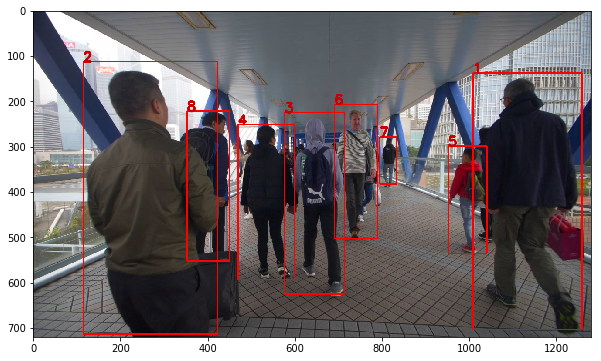

frame1.jpg


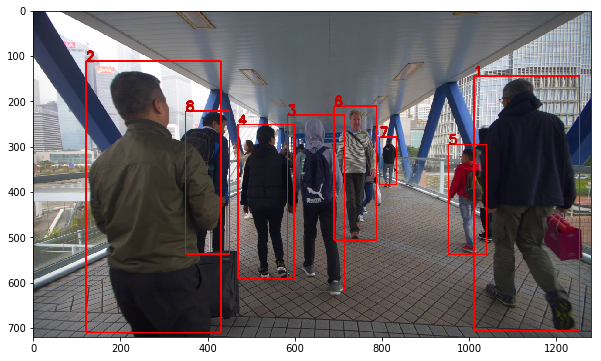

frame10.jpg


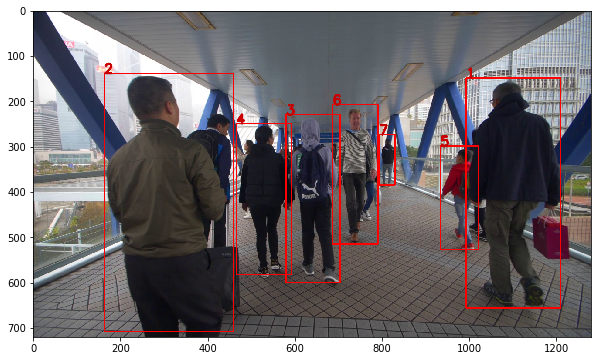

frame100.jpg


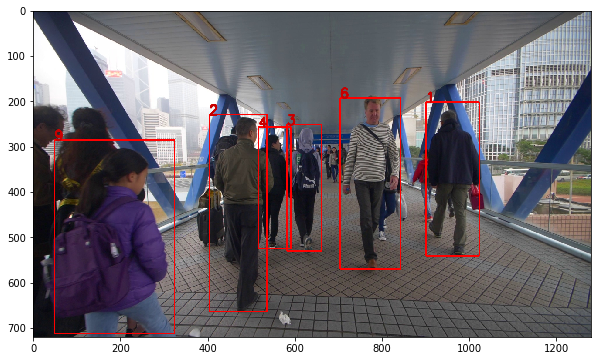

frame101.jpg


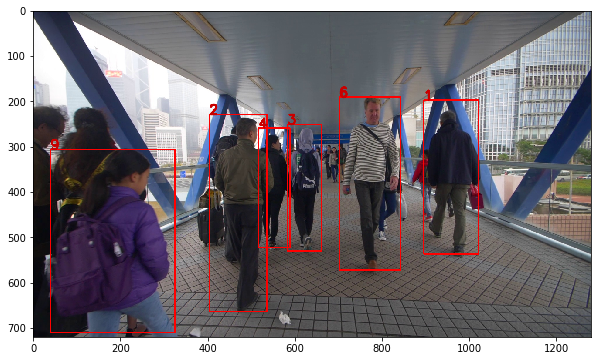

frame102.jpg


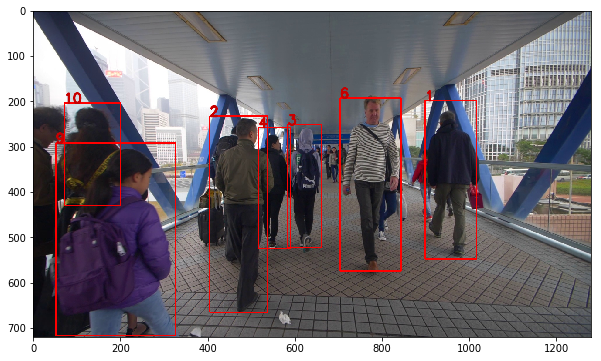

frame103.jpg


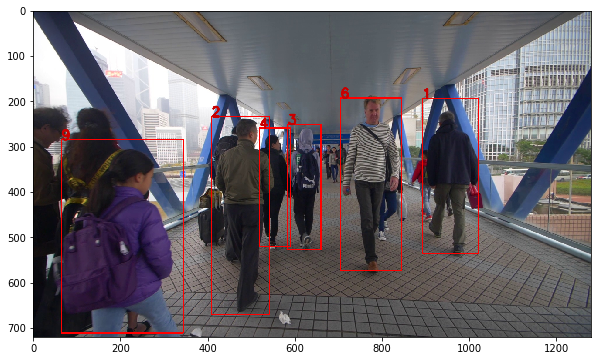

frame104.jpg


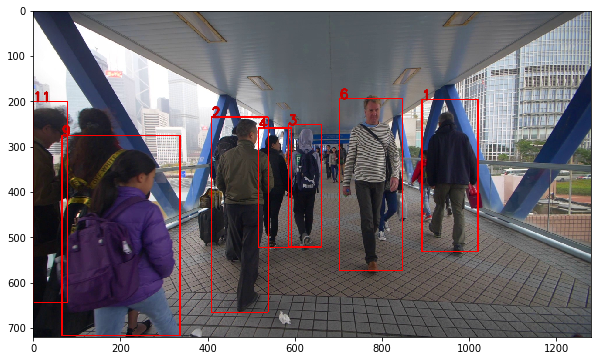

frame105.jpg


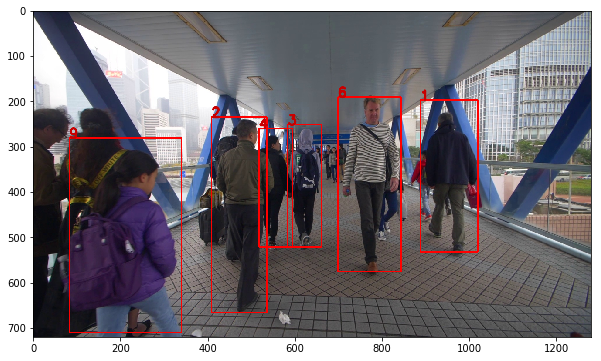

frame106.jpg


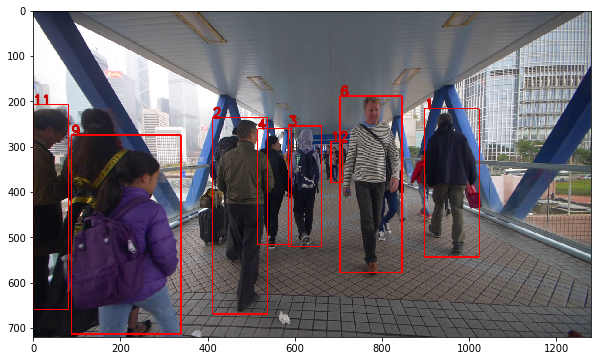

In [24]:
for img in images[:10]:
    display_image_with_id(img)

## Scatter Plot to plot the feature distribution of two different images

In [25]:
import numpy as np
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt


(63, 2)
(63, 2)


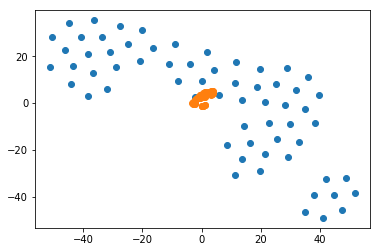

In [38]:
all_features = all_frame_df[all_frame_df['id'] == 2]
all_features_y = all_frame_df[all_frame_df['id'] == 3]
feature_vec =  all_features['feature_vector'].values
feature_vec_y =  all_features_y['feature_vector'].values
elem_list = [elem.reshape(-1,1).ravel() for elem in feature_vec]
elem_list_y = [elem.reshape(-1,1).ravel() for elem in feature_vec_y]
X = np.array(elem_list)
X_embedded = TSNE(n_components=2).fit_transform(X)
print(X_embedded.shape)
Y = np.array(elem_list_y)
Y_embedded = TSNE(n_components=2).fit_transform(Y)
print(Y_embedded.shape)
plt.scatter(X_embedded[:,0], X_embedded[:,1])
plt.scatter(Y_embedded[:,0], Y_embedded[:,1])